# Udacity Self-Driving Nanodegree
## Advanced Lane Lines

### Lane Detection Pipeline
1. Camera Calibration
2. Distortion Correction
3. Color Gradient Threshold
4. Perspective Transform

### Dependencies

In [1]:
import glob
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Camera Calibration

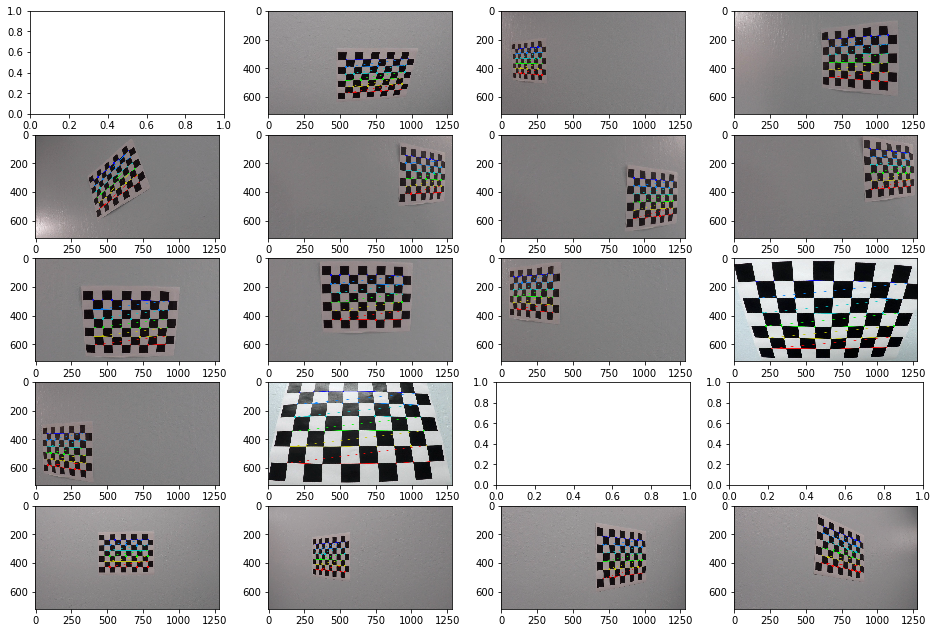

In [2]:
objgrid = np.zeros((9*6, 3), np.float32)
objgrid[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

objpts = [] # 3D points in real-world space
imgpts = [] # 2D points in image plane

images = glob.glob('camera_cal/calibration*.jpg')

grid, axes = plt.subplots(5, 4, figsize=(16, 11))
axes = axes.ravel()

for idx, filename in enumerate(images):    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    if ret == True:       
        objpts.append(objgrid)
        imgpts.append(corners)
        
        detected = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        # a blank panel means that corners were unable to be detected
        axes[idx].imshow(detected)

### Undistortion


True

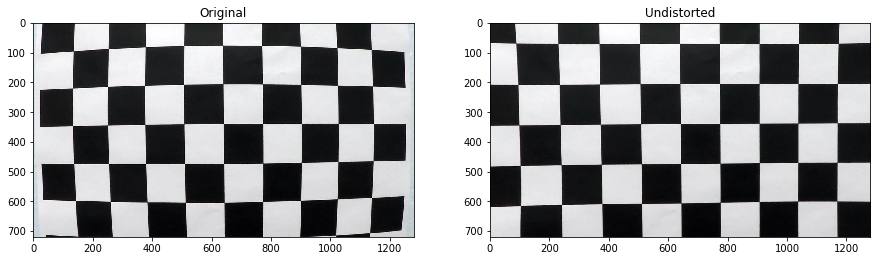

In [30]:
test_img = cv2.imread('camera_cal/calibration1.jpg')

img_size = (test_img.shape[1], test_img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
undist = cv2.undistort(test_img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('dist_pickle.p', 'wb'))

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Undistorted')
axis2.imshow(undist)

cv2.imwrite('examples/undistort_output.png', undist)

### Image Thresholding

True

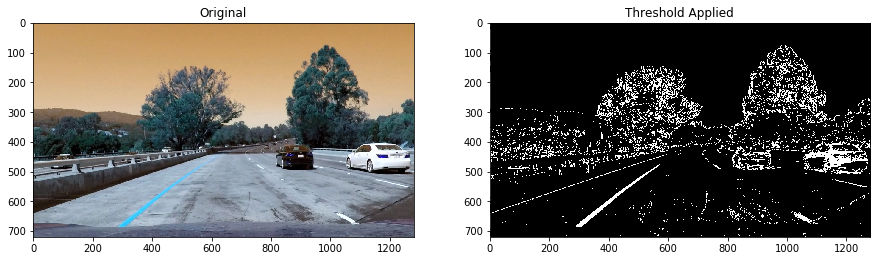

In [40]:
def apply_threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)

    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint(255 * abs_sobelx / np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined = np.zeros_like(sxbinary)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined.astype(np.uint8)

test_img = cv2.imread('test_images/test1.jpg')

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Threshold Applied')
thresh = apply_threshold(test_img)
axis2.imshow(thresh, cmap='gray')
cv2.imwrite('./examples/binary.jpg', thresh*255)

### Perspective Transform

True

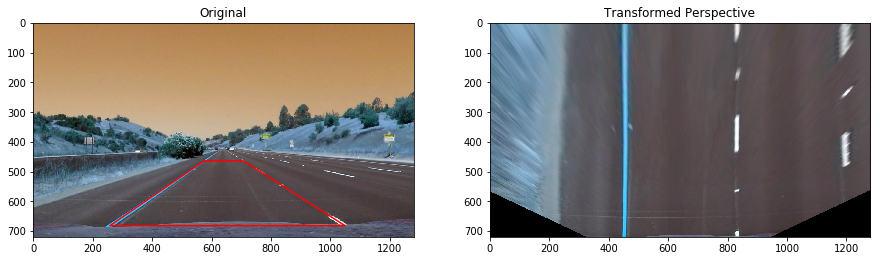

In [36]:
src = [(575, 464), (707, 464), (258, 682), (1049, 682)]
def top_perspective(img):
    height, width = img.shape[0], img.shape[1]
    dst = [(450, 0), (width - 450, 0), (450, height), (width - 450, height)]
    
    M = cv2.getPerspectiveTransform(np.float32(src), np.float32(dst))
    Minv = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped, Minv

test_img = cv2.imread('test_images/straight_lines1.jpg')
transformed, Minv = top_perspective(test_img)

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))

x = [src[0][0], src[2][0], src[3][0], src[1][0], src[0][0]]
y = [src[0][1], src[2][1], src[3][1], src[1][1], src[0][1]]

axis1.plot(x, y, color='#ff0000')
axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Transformed Perspective')
axis2.imshow(transformed)

cv2.imwrite('./examples/warped_straight_lines.jpg', transformed)

### Putting Everything Together

True

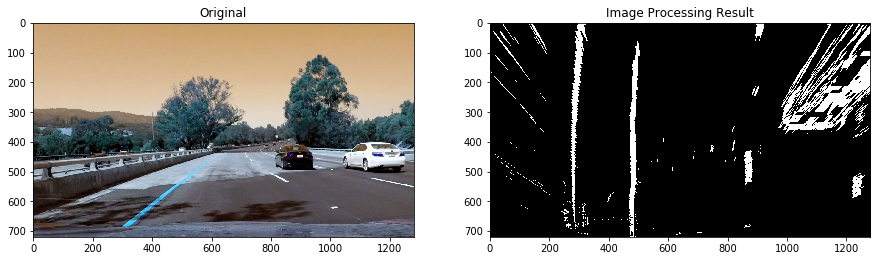

In [37]:
def pipeline(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    thresh = apply_threshold(undist)
    return top_perspective(thresh)   

test_img = cv2.imread('test_images/test4.jpg')
result, Minv = pipeline(test_img)

grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))

axis1.set_title('Original')
axis1.imshow(test_img)
axis2.set_title('Image Processing Result')
axis2.imshow(result, cmap='gray')
cv2.imwrite('./examples/pipeline.jpg',result)

### Applying the Pipeline to All Images

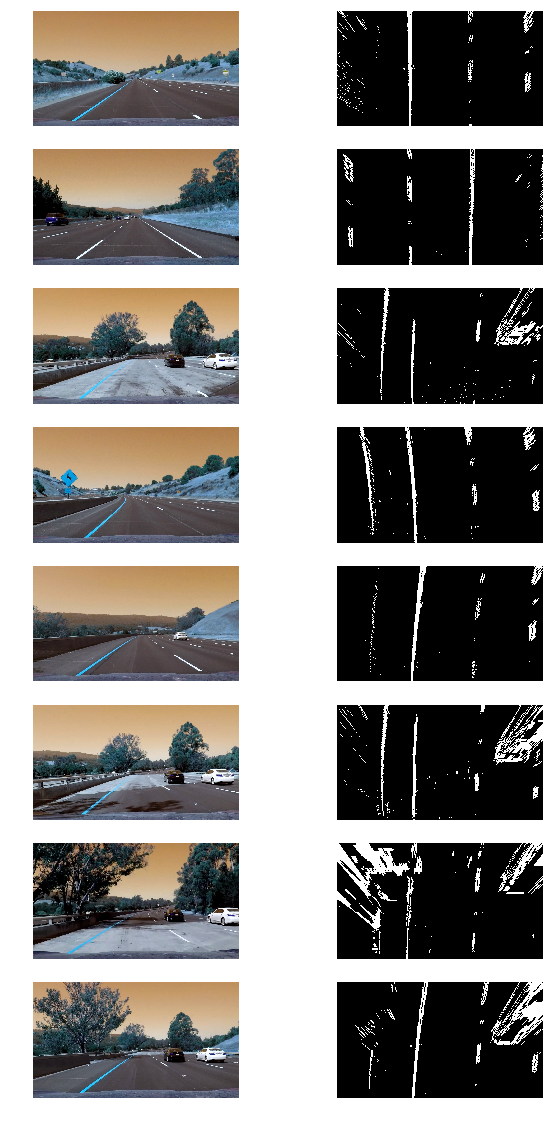

In [7]:
img_files = glob.glob('./test_images/*.jpg')

grid, axes = plt.subplots(len(img_files), 2, figsize=(10, 20))
axes = axes.ravel()

idx = 0
for f in img_files:
    img = cv2.imread(f)
    
    axes[idx].axis('off')
    axes[idx].imshow(img)
    idx += 1
    
    result, minV = pipeline(img)
    axes[idx].axis('off')
    axes[idx].imshow(result, cmap='gray')
    idx += 1

### Finding the Lane Lines

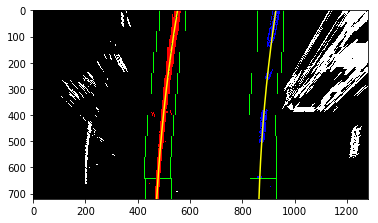

In [38]:
# Sliding widnow algorithm to determine the initial lane curvature
def sliding_window_fit(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    midpoint = np.int((histogram.shape[0]/2))
    quarterpt = np.int(midpoint//2)
    # we reduce the starting search space to avoid artifacts
    # located on the sides of the image
    leftx_base = np.argmax(histogram[quarterpt:midpoint]) + quarterpt
    
    right_edge = histogram.shape[0] - quarterpt
    rightx_base = np.argmax(histogram[midpoint:right_edge]) + midpoint

    nwindows = 9 # number of sliding windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    margin = 50
    minpix = 100

    left_lane_idxs = []
    right_lane_idxs = []

    for window in range(nwindows):
        # window boundaries in x and y
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # draw windows
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)

        # identify non-zero indices within the window
        good_left_idxs = ((nonzeroy >= win_y_low) 
                          & (nonzeroy < win_y_high) 
                          & (nonzerox >= win_xleft_low) 
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_idxs = ((nonzeroy >= win_y_low) 
                           & (nonzeroy < win_y_high) 
                           & (nonzerox >= win_xright_low) 
                           & (nonzerox < win_xright_high)).nonzero()[0]
    
        left_lane_idxs.append(good_left_idxs)
        right_lane_idxs.append(good_right_idxs)
       
        if len(good_left_idxs) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idxs]))
        if len(good_right_idxs) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_idxs]))        
            
    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)
    
    # Extract left and right line pixel locations
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]
    
    # Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return out, left_fit, right_fit, left_lane_idxs, right_lane_idxs

def visualize_fit(binary_warped, out, left_fitx, right_fitx, left_lane_idxs, right_lane_idxs):
    # Visualize lane curves through polynomial fitting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
    out[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
    plt.imshow(out)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('./examples/curve_fit.jpg')


test_img = cv2.imread('./test_images/test6.jpg')
binary_warped, minV = pipeline(test_img)
result, left_fit, right_fit, left_lane_idxs, right_lane_idxs = sliding_window_fit(binary_warped)
visualize_fit(binary_warped, result, left_fit, right_fit, left_lane_idxs, right_lane_idxs)

### Curve Fitting for Subsequent Images

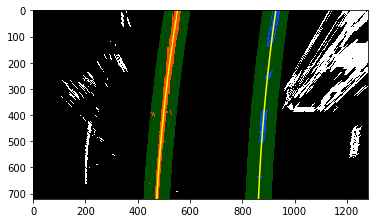

In [9]:
# We don't need to do a full image scan. We'll just use the previous
# curves and adjust it for the new image
def next_fit(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 50
    left_lane_idxs = ((nonzerox > (left_fit[0] * (nonzeroy**2)) + left_fit[1] * nonzeroy + left_fit[2] - margin)) \
                        & (nonzerox < (left_fit[0] * (nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))

    right_lane_idxs = ((nonzerox > (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] - margin))
                        & (nonzerox < (right_fit[0] * (nonzeroy**2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_idxs, right_lane_idxs

def visualize_next_fit(binary_warped, left_fit, right_fit, left_lane_idxs, right_lane_idxs):
    out = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out)
    
    margin = 50
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out[nonzeroy[left_lane_idxs], nonzerox[left_lane_idxs]] = [255, 0, 0]
    out[nonzeroy[right_lane_idxs], nonzerox[right_lane_idxs]] = [0, 0, 255]
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_line_w1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_w2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])                             
    left_line_pts = np.hstack((left_line_w1, left_line_w2))
                                 
    right_line_w1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_w2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])                        
    right_line_pts = np.hstack((right_line_w1, right_line_w2))    
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    
    result = cv2.addWeighted(out, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
# We reuse the previous test image since we don't have a set of consecutive lane images
left_fit, right_fit, left_lane_idxs, right_lane_idxs = next_fit(binary_warped, left_fit, right_fit)
visualize_next_fit(binary_warped, left_fit, right_fit, left_lane_idxs, right_lane_idxs)

### Calculating Curve Radius and Center Positioning

In [10]:
ym_per_pix = 30/720 # meters per pixel in y
xm_per_pix = 3.7/700 # meters per pixel in x

def curve_radius(binary_warped, left_lane_idxs, right_lane_idxs):    
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    y_eval = np.max(ploty)    
    
    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0]) 
    return left_curverad, right_curverad

def center_position(binary_warped, left_fit, right_fit):
    car_position = binary_warped.shape[1] / 2
    
    y = binary_warped.shape[0] 
    left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        
    lane_position = (left_fitx + right_fitx) / 2    
    return (car_position - lane_position) * xm_per_pix

left_curve, right_curve = curve_radius(binary_warped, left_lane_idxs, right_lane_idxs)
print(left_curve, 'm', right_curve, 'm')

center = center_position(binary_warped, left_fit, right_fit)
print('Center position: ', center, 'm')

2179.05738076 m 2270.9984417 m
Center position:  -0.14439232198 m


### Visualizing the Lane Area

In [11]:
def visualize_lane(warped, undist, Minv, left_fit, right_fit):
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)    
    return result

def data_overlay(img, curve, center):
    copy = np.copy(img)
    
    curve_data = 'curve_radius: {:04.3f} m'.format(curve)        
    
    direction = ''
    if center < 0:
        direction = 'left'
    elif center > 0:
        direction = 'right'
    center_data = '{:04.3f} m {} of center'.format(abs(center), direction)

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(copy, curve_data, (40,70), font, 1.0, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(copy, center_data, (40,120), font, 1.0, (200,255,155), 2, cv2.LINE_AA)
    return copy

### Putting Everything Together (Part 2)

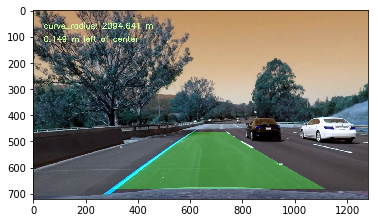

In [39]:
test_img = cv2.imread('./test_images/test2.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)
binary_warped, Minv = pipeline(img)
_, left_fit, right_fit, left_lane_idxs, right_lane_idxs = sliding_window_fit(binary_warped)    
lane_img = visualize_lane(binary_warped, undist, Minv, left_fit, right_fit)
    
left_curve, right_curve = curve_radius(binary_warped, left_lane_idxs, right_lane_idxs)
center = center_position(binary_warped, left_fit, right_fit)
final_result = data_overlay(lane_img, (left_curve + right_curve) / 2, center)

plt.imshow(final_result)
plt.savefig('./examples/final.jpg')

### Project Video

631.28369578 m 2018.92138417 m


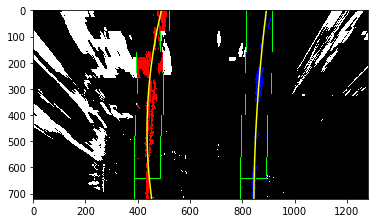

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip = VideoFileClip('project_video.mp4')
frame = clip.get_frame('00:00:41.30')
binary_warped, minV = pipeline(frame)
result, left_fit, right_fit, left_lane_idxs, right_lane_idxs = sliding_window_fit(binary_warped)
left_curve, right_curve = curve_radius(binary_warped, left_lane_idxs, right_lane_idxs)
print(left_curve, 'm', right_curve, 'm')
visualize_fit(binary_warped, result, left_fit, right_fit, left_lane_idxs, right_lane_idxs)

In [28]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

previous_left = None
previous_right = None
def process_image(img):
    global previous_left
    global previous_right
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    binary_warped, Minv = pipeline(img)
    
    if previous_left is None or previous_right is None:
        _, left_fit, right_fit, left_lane_idxs, right_lane_idxs = sliding_window_fit(binary_warped)                
    else:
        left_fit, right_fit, left_lane_idxs, right_lane_idxs = next_fit(binary_warped, previous_left, previous_right)        
        
    lane_img = visualize_lane(binary_warped, undist, Minv, left_fit, right_fit)
    left_curve, right_curve = curve_radius(binary_warped, left_lane_idxs, right_lane_idxs)   
    
    if abs(left_curve - right_curve) < 500:
        previous_left = left_fit
        previous_right = right_fit
    
    center = center_position(binary_warped, left_fit, right_fit)
    return data_overlay(lane_img, (left_curve + right_curve) / 2, center)

output_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 24%|██▍       | 303/1261 [00:53<02:49,  5.65it/s]


 48%|████▊     | 605/1261 [01:46<01:51,  5.87it/s]


 72%|███████▏  | 907/1261 [02:39<01:03,  5.62it/s]


 96%|█████████▌| 1205/1261 [03:32<00:09,  5.64it/s]


100%|█████████▉| 1260/1261 [03:42<00:00,  5.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min 7s, sys: 50.8 s, total: 4min 58s
Wall time: 3min 42s


In [34]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_file))